In [2]:
%reset -f
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from scipy.sparse import lil_matrix


def generate_full_rank_sparse_integer_system(N, density=0.01, value_range=(-10, 10), random_state=None):
    """
    フルランクなスパース整数連立一次方程式 Ax = b を生成する。
    
    N: 変数（=行数=列数）
    density: 全体に占める非ゼロ要素割合
    value_range: 非ゼロ整数値の範囲（例：(-5, 5)）
    """
    if random_state is not None:
        np.random.seed(random_state)

    A = lil_matrix((N, N), dtype=int)

    # ステップ1: 各行に1つ以上の非ゼロ（対角線に1を置くことでrankを確保）
    for i in range(N):
        val = 0
        while val == 0:
            val = np.random.randint(value_range[0], value_range[1] + 1)
        A[i, i] = val

    # ステップ2: ランダムな位置に追加で非ゼロ整数を入れる（スパース性の調整）
    total_nonzeros_target = int(N * N * density)
    current_nonzeros = N  # すでに対角にN個ある
    while current_nonzeros < total_nonzeros_target:
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        if A[i, j] == 0:
            val = 0
            while val == 0:
                val = np.random.randint(value_range[0], value_range[1] + 1)
            A[i, j] = val
            current_nonzeros += 1

    # bベクトルも整数で
    b = np.random.randint(value_range[0], value_range[1] + 1, size=N)
    if np.linalg.matrix_rank(A.toarray()) < N:
        return generate_full_rank_sparse_integer_system(N, density, value_range, random_state)

    return A.tocsr(), b

N = 5
A, b = generate_full_rank_sparse_integer_system(N, density=0.5, value_range=(-5, 5))
print(f"A.shape = {A.shape}, non zero = {A.nnz}, rank = {np.linalg.matrix_rank(A.toarray())}")
print(A.toarray()) 
print(b)

A.shape = (5, 5), non zero = 12, rank = 5
[[-3 -3  0  0  0]
 [ 0 -2 -2  3  0]
 [-1  0  4  4  0]
 [ 0  0  4  2  1]
 [ 0  0  0  0  4]]
[ 0 -4 -4  0  4]


In [2]:
from mechanics import *
import string

vars = string.ascii_lowercase[:N]

system = (
    System()
    .add_variable(' '.join(vars))
)
for i in range(N):
    system.equate(
        '+'.join([f'{A[i, j]}*{vars[j]}' for j in range(N)]),
        b[i],
    )
system.show_all()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Indices: ()
Input: ()


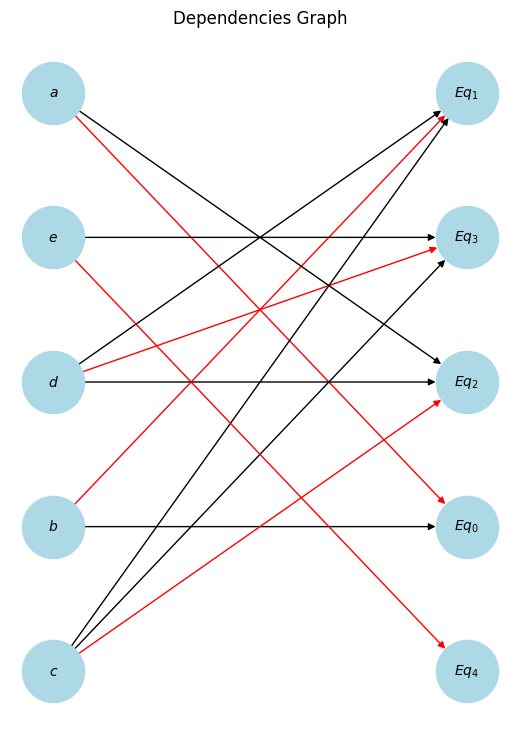

Stage(inputs=[])):
  Block #0 [] <- ()
    equations = ('Eq_4',)
    variables = [e]
    knowns    = []

  Block #1 [] <- ('#0',)
    equations = ('Eq_0', 'Eq_1', 'Eq_2', 'Eq_3')
    variables = [d, b, c, a]
    knowns    = [e]




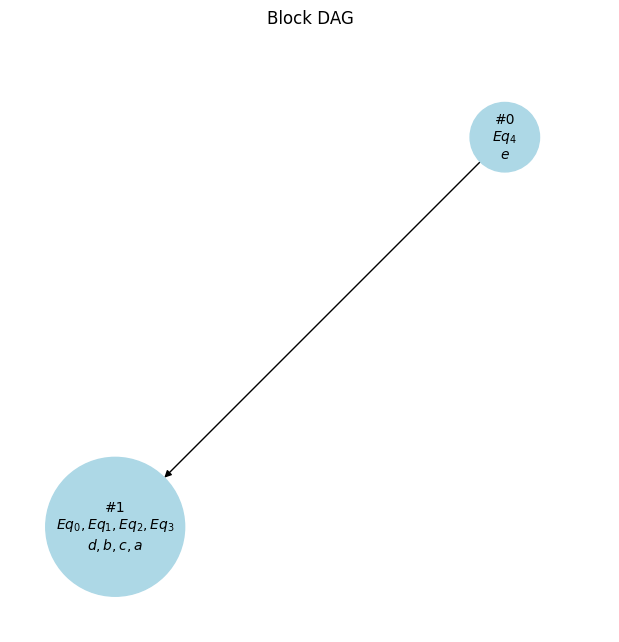

/var/folders/4n/_jcnzrss7571s_0zzmtzqtsr0000gn/T/tmp22lm1tu4/generated.f90


ld: warning: ignoring duplicate libraries: '-lgfortran'


In [3]:
solver = system.solver()
# solver.plot_dependencies()

In [5]:
result = solver.run({})
x = np.array([ result[var] for var in vars ])
print(f"x = {x}")
print(f"Ax = {A.dot(x)}")
print(f"b = {b}")
np.testing.assert_allclose(A.dot(x), b, atol=1e-10)

ValueError: unexpected array size: new_size=1, got array with arr_size=0
